In [1]:
import matplotlib.pyplot as plt
import torch
from torchvision import datasets, transforms

# Part 1. Dataset and Unpruned Netowrk performance
## About Dataset
We're using KMNIST dataset, which consists of Japanese katakana characters of 10 different labels. This dataset surves as a more advanced and challenging version of popular MNIST dataset. The dataset is available in torchvision.datasets module. We're using the train and test splits of the dataset. The dataset is split into 60,000 training images and 10,000 test images. Each image is a 28x28 grayscale image, for a total of 784 pixels in each image. Each pixel has a single pixel-value associated with it, indicating the lightness or darkness of that pixel, with higher numbers meaning darker. This pixel-value is an integer between 0 and 255, inclusive.

In [2]:
transform = transforms.Compose( [ transforms.ToTensor() , transforms.Normalize((0.5,), (0.5,)) ] )
trainset = datasets.KMNIST('PATH_TO_STORE_TRAINSET', download=True, train=True, transform=transform)
valset = datasets.KMNIST('PATH_TO_STORE_TESTSET', download=True, train=False, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=64, shuffle=True)

torch.Size([64, 1, 28, 28])
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])


<Figure size 640x480 with 0 Axes>

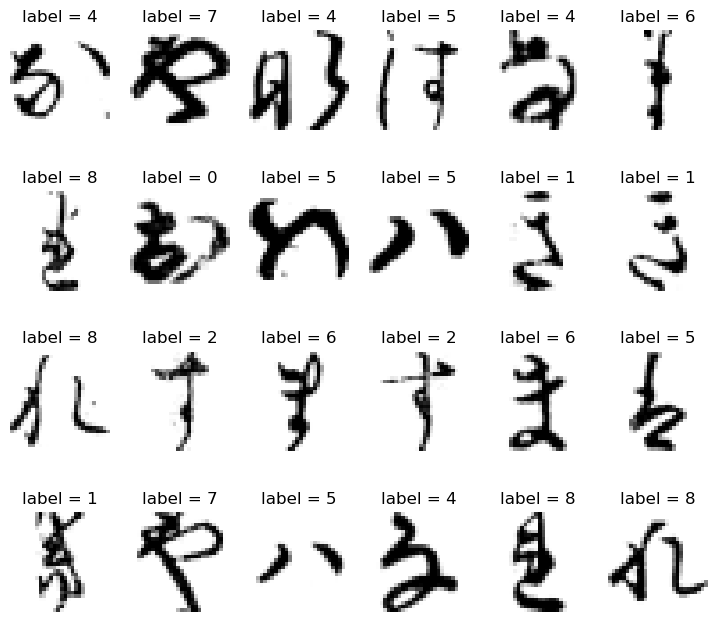

In [3]:
# Let's visualize some of images in our dataset
dataiter = iter(trainloader)
images, labels = next(dataiter)

figure = plt.figure()

num_row = 4
num_col = 6
num_of_images = num_row*num_col

fig, axes = plt.subplots(num_row, num_col, figsize=(1.5*num_col,2*num_row))

for index in range(000, num_of_images):
    ax = axes[index//num_col, index%num_col]
    ax.set_title('label = {}'.format(labels[index].item()) )
    ax.axis('off')
    ax.imshow(images[index].numpy().squeeze(), cmap='gray_r')

plt.savefig('./data/dataset.png', dpi=140)
plt.show()

## Network architecture of choice
For the purposes of this study we will be using LeNet-5 architecture (LeCun et al. 1993)

In [4]:
from models import LeNet, train_model
from models import device

model = LeNet().to(device=device)

We would be using cross-entropy loss criterion and Adam optimizer with learning rate of 0.005.

In [5]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 5e-3)
loaders = {"train": trainloader, "valid": valloader}

Let's train unpruned network without regularization and see its performance

In [6]:
accuracy, time = train_model(model, optimizer, criterion, loaders, N_epochs = 50, display = True)
print('------------------------------------------------')
print('Training time : {:.2f} s'.format(time))
print('Accuracy : {}'.format(accuracy))

Epoch: 1
Loader: train. Accuracy: 0.8985833333333333
Loader: valid. Accuracy: 0.8951
Epoch: 2
Loader: train. Accuracy: 0.9629666666666666
Loader: valid. Accuracy: 0.9108
Epoch: 3
Loader: train. Accuracy: 0.97225
Loader: valid. Accuracy: 0.9176
Epoch: 4
Loader: train. Accuracy: 0.9772666666666666
Loader: valid. Accuracy: 0.925
Epoch: 5
Loader: train. Accuracy: 0.9794
Loader: valid. Accuracy: 0.9264
Epoch: 6
Loader: train. Accuracy: 0.9827166666666667
Loader: valid. Accuracy: 0.9207
Epoch: 7
Loader: train. Accuracy: 0.9828166666666667
Loader: valid. Accuracy: 0.9292
Epoch: 8
Loader: train. Accuracy: 0.9846833333333334
Loader: valid. Accuracy: 0.9222
Epoch: 9
Loader: train. Accuracy: 0.98605
Loader: valid. Accuracy: 0.9219
Epoch: 10
Loader: train. Accuracy: 0.9846166666666667
Loader: valid. Accuracy: 0.9284
Epoch: 11
Loader: train. Accuracy: 0.98615
Loader: valid. Accuracy: 0.9281
Epoch: 12
Loader: train. Accuracy: 0.9877833333333333
Loader: valid. Accuracy: 0.9316
Epoch: 13
Loader: train

In [14]:
print('------------------------------------------------')
print('Training time : {:.2f} s'.format(time))
print('Accuracy : {}'.format(accuracy))

------------------------------------------------
Training time : 324.01 s
Accuracy : 0.9332


# Part 2. Weight regularization
Below is an example of appplying regularization function to loss and applying magnitude-based unstrusted pruning to Netowrk. Later the pruned Netowrk is being fine-tuned

In [6]:
from weight_regularization import l1_s_norm

base_model = LeNet().to(device=device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(base_model.parameters(), lr = 5e-3)
loaders = {"train": trainloader, "valid": valloader}

_, t_1 = train_model(base_model, optimizer, criterion, loaders, N_epochs = 10, reg = l1_s_norm)

In [ ]:
import torch.nn.utils.prune as prune
import copy
import numpy as np

amounts = 1e-2 * np.array([99.7, 99.6, 99.5, 99.25, 99, 98.5, 98, 97, 95, 90, 80, 70])

train_time = []
acc = []

for amount in amounts:

    model = copy.deepcopy(base_model)
    model = copy.deepcopy(base_model)

    optimizer = torch.optim.Adam(model.parameters(), lr = 5e-3)
    criterion = torch.nn.CrossEntropyLoss()

    parameters = (
    (model.conv1, 'weight'),
    (model.conv2, 'weight'),
    (model.fc1, 'weight'),
    (model.fc2, 'weight')
              )

    prune.global_unstructured(
        parameters,
        pruning_method=prune.L1Unstructured,
        amount=amount,
    )

    accuracy, t_2 = train_model(model, optimizer, criterion, loaders, N_epochs=40)

    print('Amount : {} %, Valid accuracy : {:.5f}, time {:.1f} s'.format(
        amount * 100, accuracy, t_1+t_2) )

    acc.append(accuracy)
    train_time.append(t_1 + t_2)

### Plots
All the collected data for different pruning techinques is stored in "./data/structed_pruning.json". Here we plot accuracy from number of parameters for pruned networks obtained with different regularization functions

In [11]:
total_params = sum(p.numel() for p in model.parameters())
print(total_params)

47854


In [ ]:
import json

with open("./data/structed_pruning.json", "r") as read_file:
    data = json.load(read_file)

In [18]:
import numpy as np

wr = data["weight_regularization"]

l1_param = np.round((100-np.array(wr["l1"]["amount, %"])) / 100 * total_params) * 2
l1_acc = np.array(wr["l1"]["mean_accuracy"])*100
l1_acc_err = np.array(wr["l1"]["std_accuracy"])*100

l1_s_param = np.round((100-np.array(wr["l1_s"]["amount, %"])) / 100 * total_params) * 2
l1_s_acc = np.array(wr["l1_s"]["mean_accuracy"])*100
l1_s_acc_err = np.array(wr["l1_s"]["std_accuracy"])*100

l2_param = np.round((100-np.array(wr["l2"]["amount, %"])) / 100 * total_params) * 2
l2_acc = np.array(wr["l2"]["mean_accuracy"])*100
l2_acc_err = np.array(wr["l2"]["std_accuracy"])*100

l2_s_param = np.round((100-np.array(wr["l2_s"]["amount, %"])) / 100 * total_params) * 2
l2_s_acc = np.array(wr["l2_s"]["mean_accuracy"])*100
l2_s_acc_err = np.array(wr["l2_s"]["std_accuracy"])*100

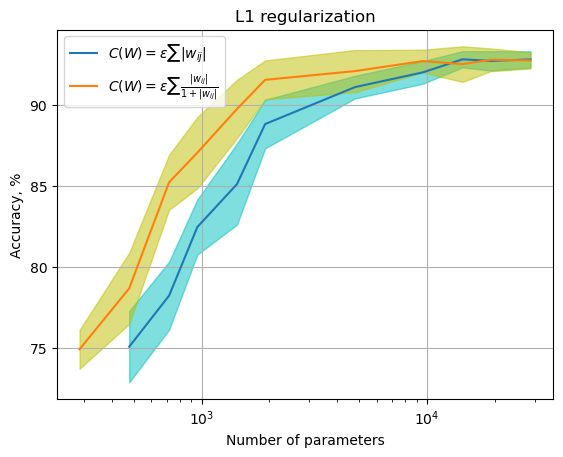

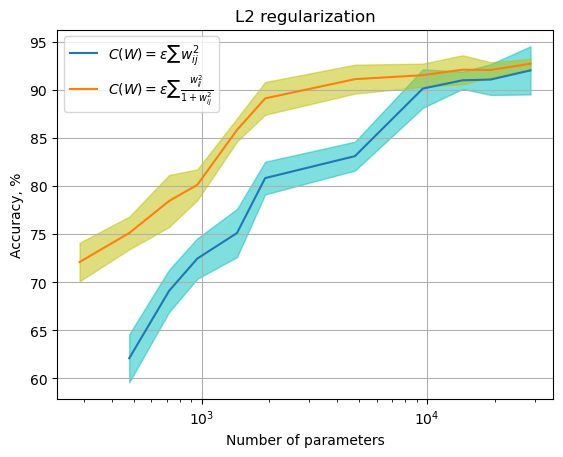

In [20]:
plt.fill_between(l1_param, l1_acc+l1_acc_err,
                l1_acc-l1_acc_err, alpha=0.5, color ='c')
plt.plot(l1_param, l1_acc, label=r'$C(W) = \epsilon \sum |w_{ij}|$')
plt.fill_between(l1_s_param, l1_s_acc+l1_s_acc_err,
                l1_s_acc-l1_s_acc_err, alpha=0.5, color ='y')
plt.title('L1 regularization')
plt.plot(l1_s_param, l1_s_acc, label=r'$C(W) = \epsilon \sum \frac{|w_{ij}|}{1+|w_{ij}|}$')
plt.grid()
plt.xlabel('Number of parameters')
plt.ylabel('Accuracy, %')
plt.legend()
plt.xscale('log')
plt.savefig('./data/l1_unstrusted', dpi=140)
plt.show()

plt.fill_between(l2_param, l2_acc+l2_acc_err,
                l2_acc-l2_acc_err, alpha=0.5, color ='c')
plt.plot(l2_param, l2_acc, label=r'$C(W) = \epsilon \sum w_{ij}^2$')
plt.fill_between(l2_s_param, l2_s_acc+l2_s_acc_err,
                l2_s_acc-l2_s_acc_err, alpha=0.5, color ='y')
plt.title('L2 regularization')
plt.plot(l2_s_param, l2_s_acc, label=r'$C(W) = \epsilon \sum \frac{w_{ij}^2}{1+w_{ij}^2}$')
plt.grid()
plt.xlabel('Number of parameters')
plt.ylabel('Accuracy, %')
plt.legend()
plt.xscale('log')
plt.savefig('./data/l2_unstrusted', dpi=140)
plt.show()


# Part 3. Optimal brain damage

In [6]:
base_model = LeNet().to(device=device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(base_model.parameters(), lr = 5e-3)
loaders = {"train": trainloader, "valid": valloader}

_, t_1 = train_model(base_model, optimizer, criterion, loaders, N_epochs = 10)

In [7]:
loss = 0

N = 10
i = 0

for x_batch, y_batch in trainloader:
    i += 1
    outp = base_model(x_batch)
    loss += criterion(outp, y_batch)
    if i == N:
        break

In [8]:
def pth_jacobian(y, x, create_graph = False):
    jac = []
    flat_y = y.reshape(-1)
    grad_y = torch.zeros_like(flat_y)
    grad_y = torch.zeros_like(flat_y)
    for i in range(len(flat_y)):
        grad_y[i] = 1.
        grad_x, = torch.autograd.grad(flat_y, x, grad_y, retain_graph=True, create_graph=create_graph)
        grad_x = grad_x.reshape(x.shape)
        jac.append(grad_x.reshape(x.shape))
        grad_y[i] = 0.

    return torch.stack(jac, axis = 0).reshape(y.shape + x.shape)

In [9]:
parameters = (
    (base_model.conv1, 'conv1'),
    (base_model.conv2, 'conv2'),
    (base_model.fc1, 'fc1'),
    (base_model.fc2, 'fc2'),
    (base_model.fc3, 'fc3')
              )

h_ii = {}

for module, name in parameters:
    weights = module.weight
    grad = pth_jacobian(loss, weights, create_graph=True)

    flat_y = grad.reshape(-1)
    h_ii[name] = torch.zeros_like(flat_y)
    for i in range(len(flat_y)):
        grad_x, = torch.autograd.grad(flat_y[i], weights, retain_graph=True)
        h_ii[name][i] = grad_x.reshape(-1)[i].item()

    h_ii[name] = h_ii[name].reshape(weights.shape)

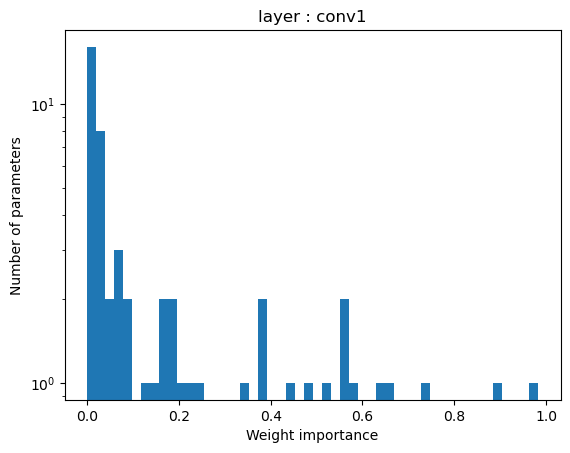

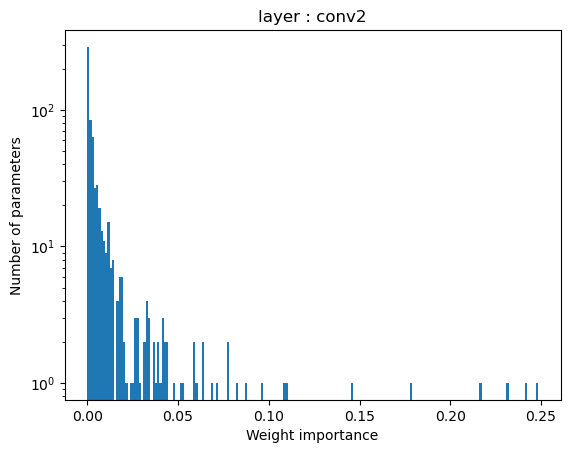

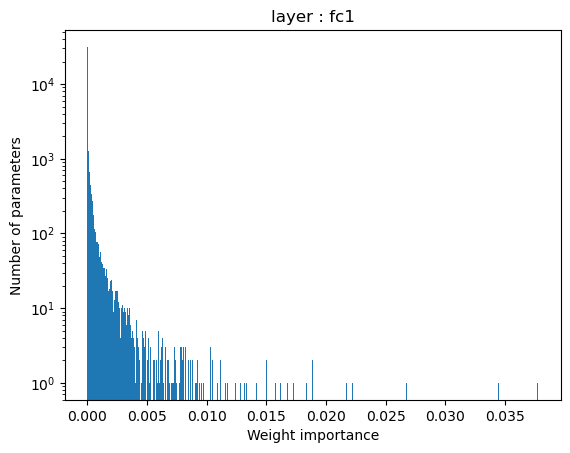

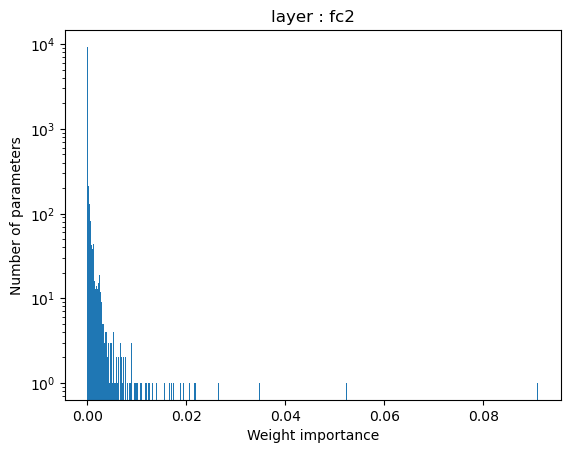

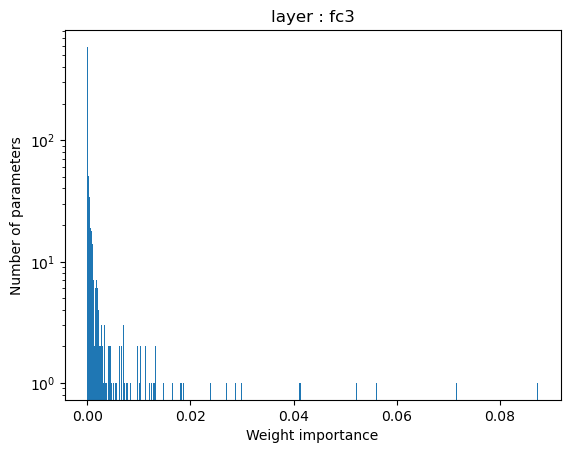

In [10]:
parameters = {
    'conv1' : base_model.conv1,
    'conv2' : base_model.conv2,
    'fc1' : base_model.fc1,
    'fc2' : base_model.fc2,
    'fc3' : base_model.fc3
}

i = 0

s_all = {}

for name, hes in h_ii.items():
    i += 1
    s_ii = 1/2 * hes * parameters[name].weight ** 2
    plt.title('layer : {}'.format(name))

    s_all[name] = s_ii

    if i == 1:
        bins = 50
    elif i == 2:
        bins = 200
    elif i == 3:
        bins = 500
    elif i == 4:
        bins = 500
    elif i == 5:
        bins = 500

    plt.hist(s_ii.reshape(-1).detach().numpy(), bins, log=True)
    plt.xlabel('Weight importance')
    plt.ylabel('Number of parameters')
    plt.savefig('./data/layer_{}.png'.format(name), dpi = 140)
    plt.show()

Now let's do some pruning based on estimation of weight importance

In [15]:
import numpy as np

s_t_list = np.logspace(-6, -2.6, 15)
amount = []

for s_th in s_t_list:

    num = 0.

    for name, s_ii in s_all.items():
        num += torch.sum(s_ii > s_th).item()

    num /= total_params
    amount.append(num)


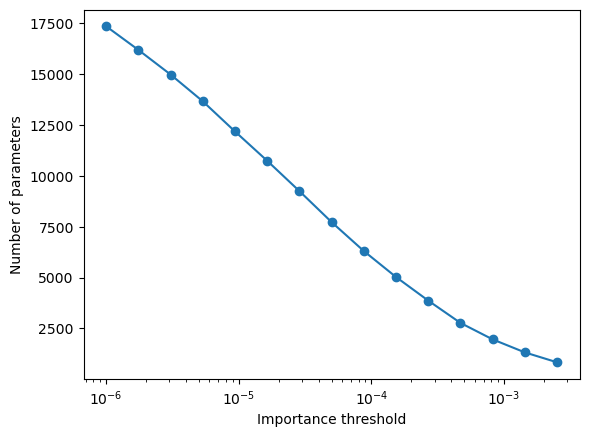

In [18]:
plt.plot(s_t_list, np.array(amount) * total_params, marker='o')
plt.xscale('log')
plt.xlabel('Importance threshold')
plt.ylabel('Number of parameters')
plt.savefig('./data/threshold.png', dpi = 140)

In [21]:
import torch.nn.utils.prune as prune
import copy

train_time = []
acc = []

for s_th in s_t_list:

    model = copy.deepcopy(base_model)

    optimizer = torch.optim.Adam(model.parameters(), lr = 5e-3)
    criterion = torch.nn.CrossEntropyLoss()

    parameters = {
        'conv1' : model.conv1,
        'conv2' : model.conv2,
        'fc1' : model.fc1,
        'fc2' : model.fc2,
        'fc3' : model.fc3
    }

    for name, module in parameters.items():
        mask = s_all[name] >= s_th
        torch.nn.utils.prune.CustomFromMask.apply(module, 'weight', mask)

    accuracy, t_2 = train_model(model, optimizer, criterion, loaders, N_epochs=30)

    print('s_th : {}, Valid accuracy : {:.5f}, time {:.1f} s'.format(
        s_th, accuracy, t_1+t_2) )

    acc.append(accuracy)
    train_time.append(t_1 + t_2)

print(acc)

s_th : 1e-06, Valid accuracy : 0.92860, time 308.6 s
s_th : 1.7492711874398423e-06, Valid accuracy : 0.92670, time 309.7 s
s_th : 3.059949687207196e-06, Valid accuracy : 0.91870, time 348.6 s
s_th : 5.352681822847106e-06, Valid accuracy : 0.92610, time 305.8 s
s_th : 9.363292088239417e-06, Valid accuracy : 0.92810, time 279.2 s
s_th : 1.6378937069540647e-05, Valid accuracy : 0.92470, time 360.8 s
s_th : 2.865120269663782e-05, Valid accuracy : 0.91540, time 384.5 s
s_th : 5.011872336272725e-05, Valid accuracy : 0.92090, time 356.7 s
s_th : 8.767123872968687e-05, Valid accuracy : 0.91500, time 277.9 s
s_th : 0.00015336077187700107, Valid accuracy : 0.90480, time 277.6 s
s_th : 0.00026826957952797245, Valid accuracy : 0.90590, time 275.8 s
s_th : 0.0004692762459348836, Valid accuracy : 0.90230, time 279.5 s
s_th : 0.0008208914159638254, Valid accuracy : 0.86940, time 279.2 s
s_th : 0.0014359617019622142, Valid accuracy : 0.82420, time 278.0 s
s_th : 0.0025118864315095794, Valid accuracy :

## Plots

In [37]:
opt_bd_param = (100-np.array(data["taylor_pruning"]["optimal_brain_damage"]["amount, %"])) / 100 * total_params
opt_bd_acc = np.array(data["taylor_pruning"]["optimal_brain_damage"]["mean_accuracy"]) * 100
opt_bd_acc_err = np.array(data["taylor_pruning"]["optimal_brain_damage"]["std_accuracy"]) * 100

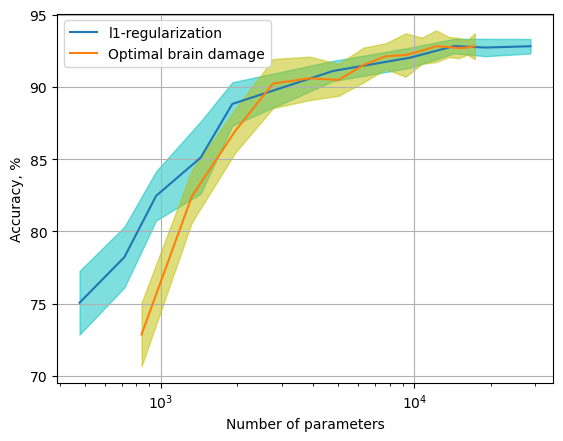

In [38]:
plt.fill_between(l1_param, l1_acc+l1_acc_err,
                l1_acc-l1_acc_err, alpha=0.5, color ='c')
plt.plot(l1_param, l1_acc, label=r'l1-regularization')
plt.fill_between(opt_bd_param, opt_bd_acc+opt_bd_acc_err,
                opt_bd_acc-opt_bd_acc_err, alpha=0.5, color ='y')
plt.plot(opt_bd_param, opt_bd_acc, label=r'Optimal brain damage')
plt.grid()
plt.xlabel('Number of parameters')
plt.ylabel('Accuracy, %')
plt.legend()
plt.xscale('log')
plt.savefig('./data/opt_brain_damage', dpi=140)
plt.show()